In [4]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1 data processing

In [12]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(time):
    year, month, day, hour, minute, second = map(int, time)
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# 加载 mat 文件
def loadMat(matfile):
    matdata = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]
    col = matdata[filename][0][0][0][0]

    data = []
    for i in range(col.shape[0]):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# 提取锂电池容量
def getBatteryData(Battery):
    cycle, capacity, bat_volt, bat_curr, temp, env_temp, time = [], [], [], [], [], [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            bat_volt.append(Bat['data']['Voltage_measured'][0])
            bat_curr.append(Bat['data']['Current_measured'][0])
            temp.append(Bat['data']['Temperature_measured'][0])
            # load_volt.append(Bat['data']['Voltage_charge'][0])
            # load_curr.append(Bat['data']['Current_charge'][0])
            time.append(Bat['time'])
            env_temp.append(Bat['temp'])
            cycle.append(i)
            i += 1
    return [cycle, capacity, bat_volt, bat_curr, temp, env_temp, time]


Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = r'D:/FOLDER/CAREER/于组科研助理/DATASETS/NASA_Prognostics_Data_Repository/MIX_Battery_Data_Set/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryData(data)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [13]:
def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        x.append(sequence[i:i+window_size])
        y.append(sequence[i+window_size][0])

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


def get_train_valid_test(data_dict, test_name='B0018', feature_size=8, valid_ratio=0.2, random_state=42):
    # 构建训练集（去掉测试电池）
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != test_name:
            multi_data = np.stack([np.array(v[i]) for i in range(1, 6)], axis=1)  # shape: (N, 5)
            data_x, data_y = build_instances(multi_data, feature_size)
            if train_x is None:
                train_x, train_y = data_x, data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
    
    # 划分验证集
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=valid_ratio, random_state=random_state)
    
    # 构建测试集
    test_sequence = data_dict[test_name]
    multi_test = np.stack([np.array(test_sequence[i]) for i in range(1, 6)], axis=1)
    test_x, test_y = build_instances(multi_test, feature_size)

    return train_x, train_y, valid_x, valid_y, test_x, test_y


def convert_to_tensor(*args):
    return [torch.from_numpy(arr).float() for arr in args]


def reshape_data(*args):
    # 将数据重塑为 (N, feature_size)
    return [data.reshape(data.shape[0], -1) for data in args]

train_x, train_y, valid_x, valid_y, test_x, test_y = get_train_valid_test(Battery, test_name='B0018', feature_size=16)
train_x, train_y, valid_x, valid_y, test_x, test_y = convert_to_tensor(train_x, train_y, valid_x, valid_y, test_x, test_y)
train_x, train_y, valid_x, valid_y, test_x, test_y = reshape_data(train_x, train_y, valid_x, valid_y, test_x, test_y)

train_set = TensorDataset(train_x, train_y)
valid_set = TensorDataset(valid_x, valid_y)
test_set = TensorDataset(test_x, test_y)

batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

In [14]:
# 打印 train_loader 的形状
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Train batch {batch_idx + 1}: data shape = {data.shape}, target shape = {target.shape}")
    break  # 打印第一个批次并退出（避免打印过多）

Train batch 1: data shape = torch.Size([64, 80]), target shape = torch.Size([64, 1])


## 2 model training

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultivariateVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MultivariateVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc_mu(h2), self.fc_logvar(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # MSE loss适合多变量回归
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

## 2.3 train for model

## 2.4 setting and training for overall performance

In [10]:
feature_size = 16
epochs = 500
lr = 0.001           # learning rate
hidden_dim = 128
num_layers = 1
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0
metric = 'rmse'
device = 'cpu'

## 2.5 prediction for figures

**select the seed of the best performance**

NameError: name 'prediction_list' is not defined

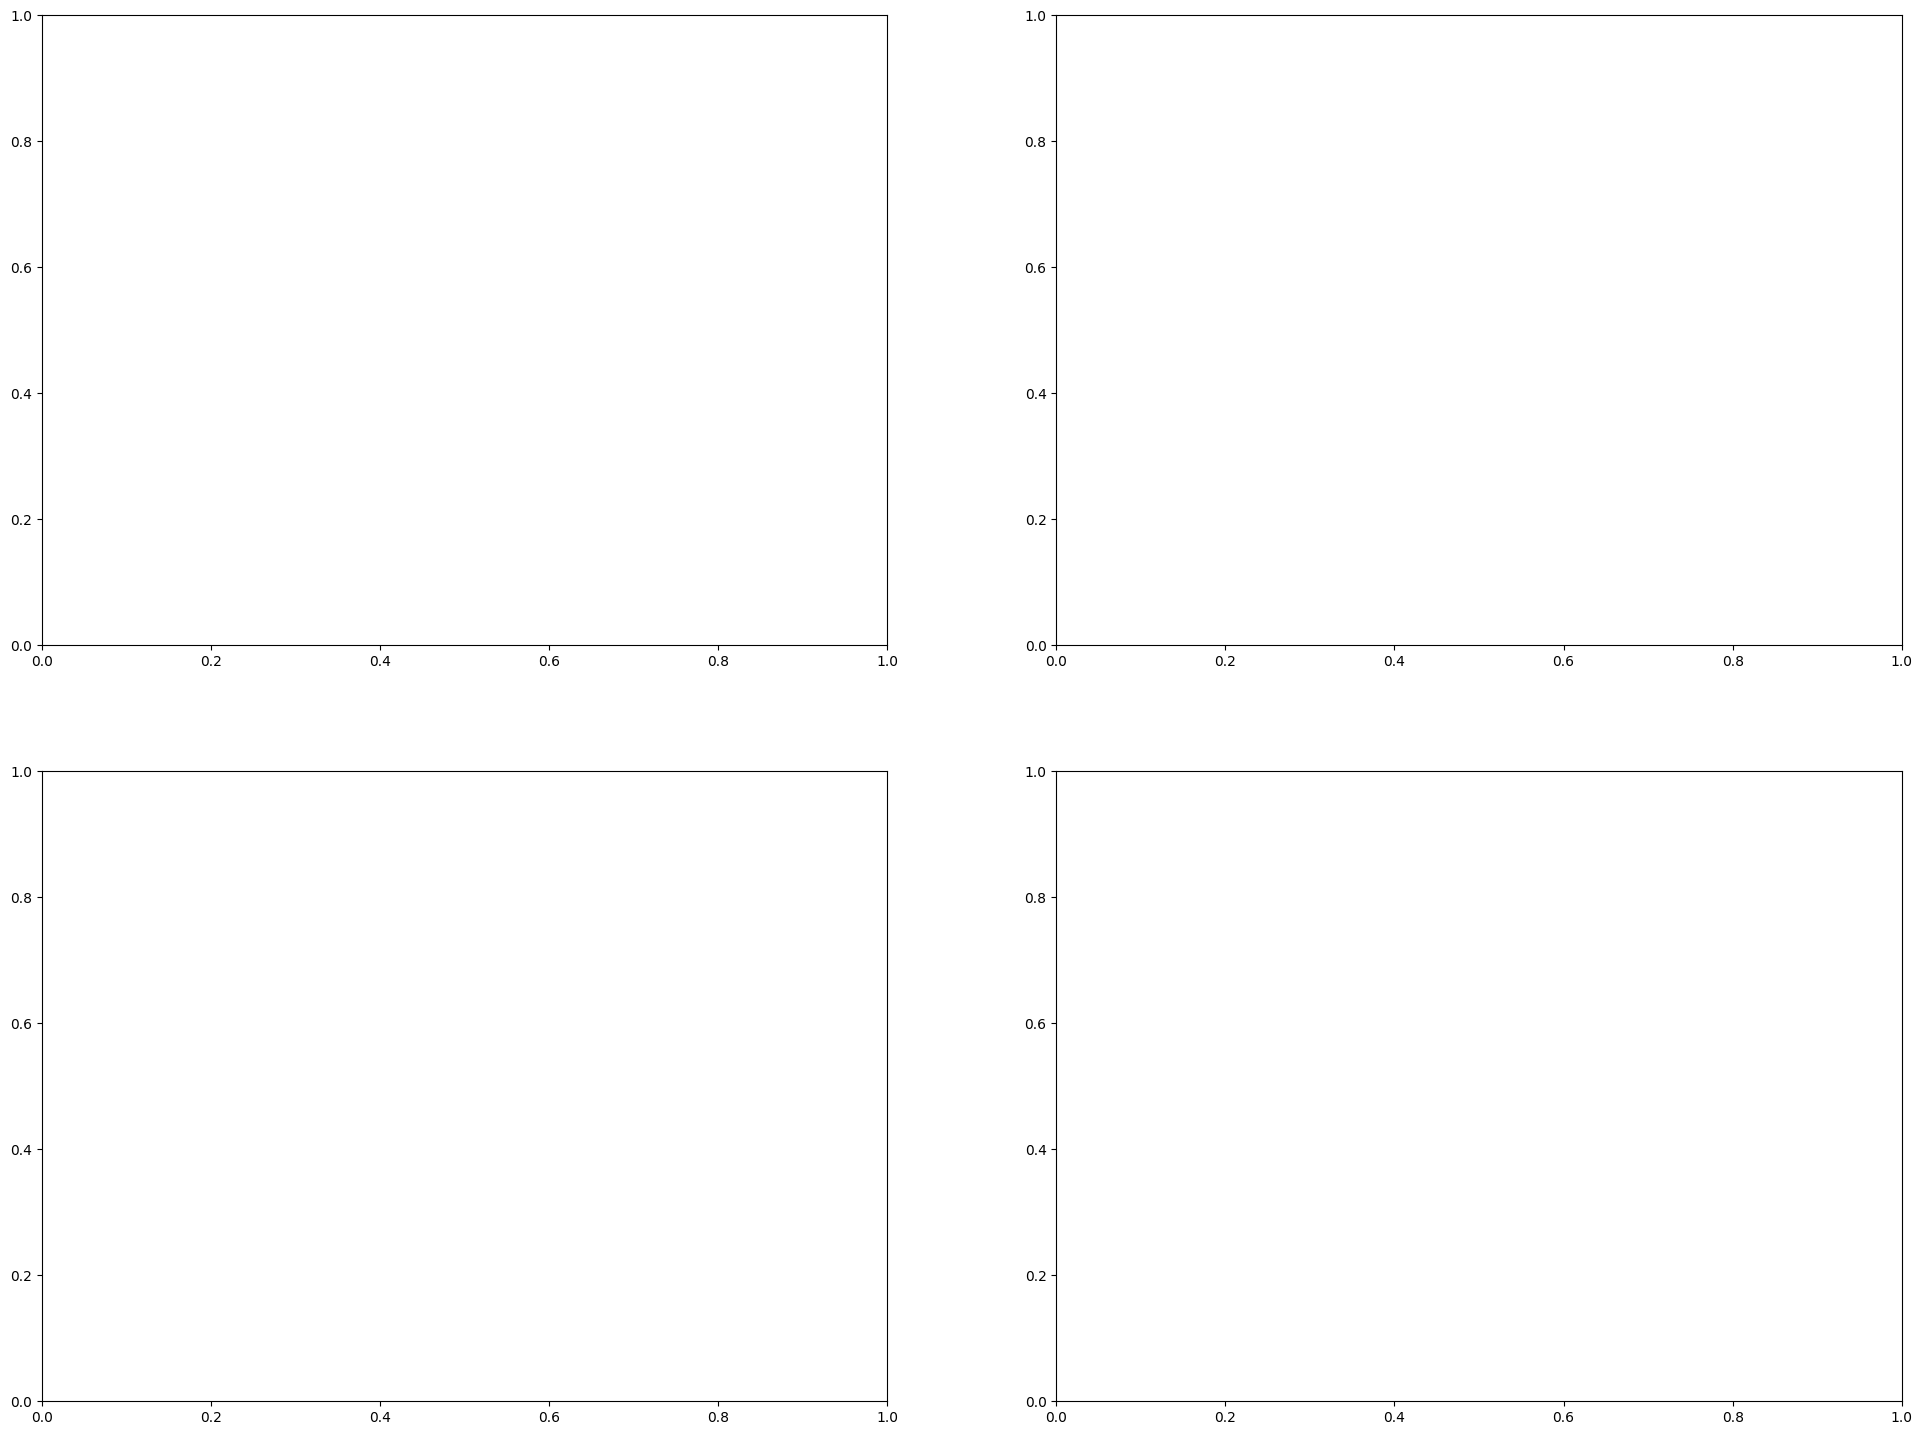

In [11]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name][1]
        predict_data = prediction_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, predict_data, 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()